# Objetivo

Nesta aula veremos algumas das funções de filtragem que vimos em PDI de forma que seja expandida para 3D.

Serão os tópicos:
* Função Gaussiana Generalizada (ou distribuição normal multivariada)

$ p(x) = \frac{1}{\theta * \sqrt{2 * \pi}} * e^(\frac{-1}{2} * (\frac{x-\varphi}{\theta}))²$

$\theta$ vetor: vetor representando um ponto (x,y)

$\varphi$ vetor: vetor da posição do pico

$\sigma$: matriz de covariância

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itk
from itkwidgets import view

# Exemplo

A covariancia pode ser calculada como

$con(x, y) = \frac{1}{N} \sum_{i=1} e^{N((xi - ux) * (yi - uy))}$

con(x, y) = 1/N SUM, i=1 e ^N((xi- ux)*(yi - uY))

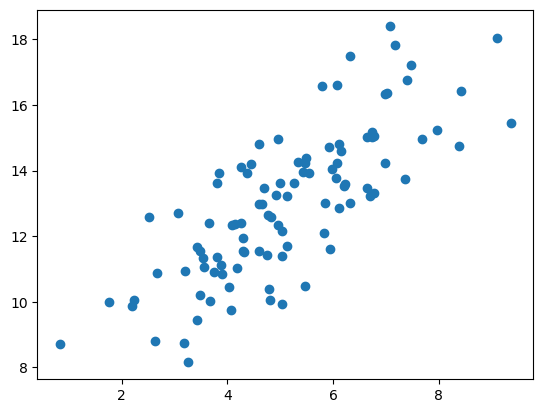

In [2]:
data = np.loadtxt('dados.txt')

plt.plot(data[:, 0], data[:, 1], 'o')

In [3]:
def covariance(x, y):
    
    u_x = np.mean(x)
    u_y = np.mean(y)
    cov = np.mean((x - u_x) * (y - u_y))
    return cov

averages = np.mean(data, axis = 0)
cov_mat = np.zeros((2, 2))

x = data[:, 0]
y = data[:, 1]

cov_mat[0, 0] = covariance(x, x)
cov_mat[1, 1] = covariance(y, y)

cov_mat[0, 1] = covariance(x, y)
cov_mat[1, 0] = cov_mat[0, 1]

print(averages)
print(cov_mat)

[ 5.1221 12.9931]
[[2.60710459 2.80774449]
 [2.80774449 5.01084139]]


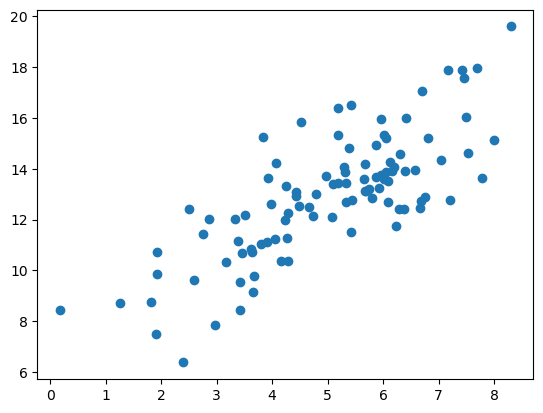

In [4]:
data_range = np.random.multivariate_normal(averages, cov_mat, size = 100)
plt.plot(data_range[:, 0], data_range[:, 1], 'o')

# Criação de uma função Gaussiana generalizada

In [5]:
def create_column_vector(arr):

    if isinstance(arr, list) or isinstance(arr, tuple):
        arr = np.array(arr)
    if arr.ndim==1:
        arr = arr[np.newaxis].T
    elif arr.ndim == 2:
        if arr.shape[0] == 1:
            arr = arr.T
    
    return arr

def gauss_3d(r, averages, covariance_mat, is_cov_invert = False):
    
    if is_cov_invert:
        covariance_mat_inv = covariance_mat
    else:
        covariance_mat_inv = np.linalg.inv(covariance_mat)
        
    r = create_column_vector(r)
    averages = create_column_vector(averages)
    
    r_diff = r - averages
    
    prod = np.dot(np.dot(r_diff.T, covariance_mat_inv), r_diff)
    
    return np.exp(-prod/2)    

def get_gauss_coords(sigma, std_range, size):
    
    gauss_coords = np.linspace(0, sigma*std_range, size//2 + 1)
    
    gaus_coords_inv = -gauss_coords[1:][::-1]
    
    gauss_coords = np.concatenate((gaus_coords_inv,
                                   gauss_coords)
                                 )
    return gauss_coords    

def create_3d_gaussian(covariance_mat, std_ranges, img_shape):
    variances = np.diag(covariance_mat) #extrai diagonal da matriz
    
    sigma = np.sqrt(variances)
    
    plane_coords = get_gauss_coords(sigma[0], std_ranges[0], img_shape[0])
    row_coords = get_gauss_coords(sigma[1], std_ranges[1], img_shape[1])
    col_coords = get_gauss_coords(sigma[2], std_ranges[2], img_shape[2])
    
    covariance_mat_inv = np.linalg.inv(covariance_mat)
    averages = (0, 0, 0)
    
    gaussian = np.zeros(img_shape)
    
    for plane_idx, plane_coord in enumerate(plane_coords):
        
        for row_idx, row_coord in enumerate(row_coords):

            for col_idx, col_coord in enumerate(col_coords):
                r = [plane_coord, row_coord, col_coord]
                g_val = gauss_3d(r, averages, covariance_mat_inv, is_cov_invert = True)
                gaussian[plane_idx, row_idx, col_idx] = g_val
    gaussian = gaussian/np.sum(gaussian)
    
    return gaussian

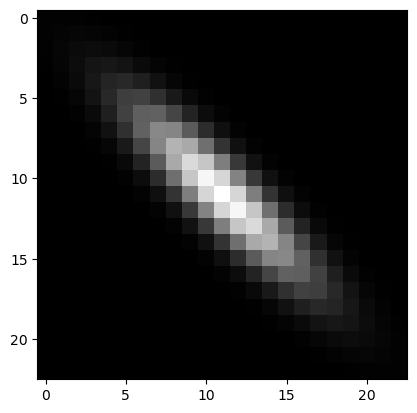

In [6]:
sigma = 3
cov = 8
covariance_mat = np.array([[sigma**2, 0, 0],
                           [0, sigma**2, cov],
                           [0, cov, sigma**2]])

std_ranges = (3, 3, 3)
img_shape = (23, 23, 23)
g = create_3d_gaussian(covariance_mat, std_ranges, img_shape)

plt.imshow(g[1, :, :], 'gray')

In [7]:
g_ = (255*g/np.max(g)).astype(np.uint8)
view(g_)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

In [8]:
get_gauss_coords(1, 3, 10)

array([-3. , -2.4, -1.8, -1.2, -0.6,  0. ,  0.6,  1.2,  1.8,  2.4,  3. ])